**Imports**

In [83]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import pathlib as Path
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


**Data Loading and Exploration**

In [84]:
df_train = pd.read_csv('../input/train.csv')
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [49]:
df_train.info()
#object type will need processing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [50]:
df_train.describe()
#0 passenger!?
#3.526282e+06/3600 ~= 979 522 778 hours what the duck!?
#Target's mean is 9.594923e+02

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


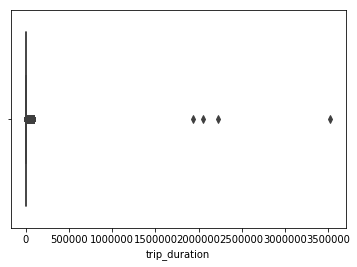

In [51]:
sns.boxplot(x=df_train['trip_duration'])

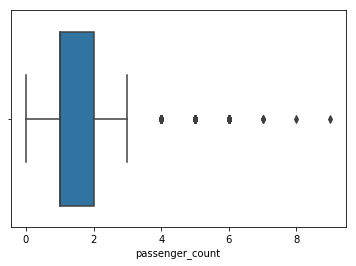

In [52]:
sns.boxplot(x=df_train['passenger_count'])

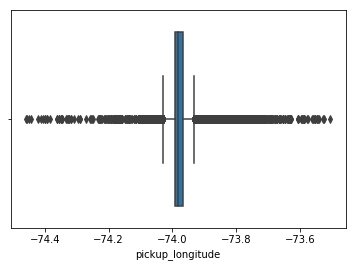

In [67]:
sns.boxplot(x=df_train['pickup_longitude'])
#sns.boxplot(x=df_train['pickup_latitude'])

In [85]:
#Let's put away the data with more than 2h of trip duration ---> the boxplot(twist) after first filter point towards <2000, let'say 1 hour(3600)
df_train = df_train[(df_train.trip_duration < 3600)]
#And with 0 passenger ---> see boxplot
df_train = df_train[(df_train.passenger_count > 0)]
df_train = df_train[(df_train.passenger_count < 5)]
#I spy with my little eyes some weird coordinates
df_train = df_train[(df_train.pickup_latitude < 41)]
df_train = df_train[(df_train.pickup_latitude > 40.5)]
df_train = df_train[(df_train.pickup_longitude > -74.5)]
df_train = df_train[(df_train.pickup_longitude < -73.5)]


df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.320902e+06,1.320902e+06,1.320902e+06,1.320902e+06,1.320902e+06,1.320902e+06,1.320902e+06
mean,1.490332e+00,1.311047e+00,-7.397419e+01,4.075125e+01,-7.397369e+01,4.075202e+01,8.112637e+02
std,4.999067e-01,6.569525e-01,3.664269e-02,2.746830e-02,3.662083e-02,3.248743e-02,5.845429e+02
min,1.000000e+00,1.000000e+00,-7.445901e+01,4.050629e+01,-7.981798e+01,3.639812e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399193e+01,4.073755e+01,-7.399134e+01,4.073609e+01,3.950000e+02
50%,1.000000e+00,1.000000e+00,-7.398183e+01,4.075417e+01,-7.397978e+01,4.075457e+01,6.570000e+02
75%,2.000000e+00,1.000000e+00,-7.396767e+01,4.076836e+01,-7.396318e+01,4.076985e+01,1.060000e+03
max,2.000000e+00,4.000000e+00,-7.350582e+01,4.099802e+01,-7.034608e+01,4.392103e+01,3.599000e+03


In [ ]:
#df_train['vendor_id'].nunique()
#df_train['passenger_count'].nunique()
#df_train['store_and_fwd_flag'].nunique()

**Data Processing**

In [86]:
#Let's create a function to avoid repetition with test.csv
def process_dataset(df):
    #Datetime casting and parsing
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['hour_in_month'] = ((df['pickup_day'] * 24) + df['pickup_hour'])    
    
    #Let's calculate the distance via long/lat of pickup and dropoff via old pal' Pythagore
    df['lat_delta'] = np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
    df['long_delta'] = np.abs(df['pickup_longitude'] - df['dropoff_longitude'])
    df['straight_distance'] = np.sqrt(np.square(df['lat_delta']) + np.square(df['long_delta']))
    #another idea : the streets of nyc are more or less perpendicular so maybe lat_delta + long_delta is a better distance evaluation
    df['driving_distance'] = df['lat_delta'] + df['long_delta']
    
    #Get dummies
    df['store_and_fwd_flag'] = pd.get_dummies(df['store_and_fwd_flag'], drop_first=True)
    df['vendor_id'] = pd.get_dummies(df['vendor_id'], drop_first=True)
    
    #selecting columns
    selected_columns = ['pickup_longitude', 'pickup_latitude', 
                        'dropoff_longitude', 'dropoff_latitude', 
                        'pickup_year', 'pickup_month', 'pickup_hour', 
                        'pickup_dayofweek', 'pickup_day', 'hour_in_month', 
                        'straight_distance', 'driving_distance', 'store_and_fwd_flag', 'passenger_count', 'vendor_id']    
    X = df[selected_columns]
    
    return X

In [87]:
X_train = process_dataset(df_train)
y = df_train['trip_duration']

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1321046 entries, 0 to 1458643
Data columns (total 15 columns):
pickup_longitude      1321046 non-null float64
pickup_latitude       1321046 non-null float64
dropoff_longitude     1321046 non-null float64
dropoff_latitude      1321046 non-null float64
pickup_year           1321046 non-null int64
pickup_month          1321046 non-null int64
pickup_hour           1321046 non-null int64
pickup_dayofweek      1321046 non-null int64
pickup_day            1321046 non-null int64
hour_in_month         1321046 non-null int64
straight_distance     1321046 non-null float64
driving_distance      1321046 non-null float64
store_and_fwd_flag    1321046 non-null uint8
passenger_count       1321046 non-null int64
vendor_id             1321046 non-null uint8
dtypes: float64(6), int64(7), uint8(2)
memory usage: 143.6 MB


**Model initialising and training**

In [88]:
rf = RandomForestRegressor()
#too many data for a cross validation, let's split!
rs = ShuffleSplit(n_splits=3, train_size =.20, test_size=.25, random_state=0)
losses = -cross_val_score(rf, X_train, y, cv = rs, scoring = 'neg_mean_squared_log_error')
losses.mean()


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.17345094915207102

In [89]:
rf.fit(X_train, y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

**Model Testing**

In [90]:
df_test = pd.read_csv('../input/test.csv')
X_test = process_dataset(df_test)
X_test.head()
#Of course nether dropoff_datetime nor trip duration

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_year,pickup_month,pickup_hour,pickup_dayofweek,pickup_day,hour_in_month,straight_distance,driving_distance,store_and_fwd_flag,passenger_count,vendor_id
0,-73.988129,40.732029,-73.990173,40.756680,2016,6,23,3,30,743,0.024735,0.026695,0,1,0
1,-73.964203,40.679993,-73.959808,40.655403,2016,6,23,3,30,743,0.024979,0.028984,0,1,0
2,-73.997437,40.737583,-73.986160,40.729523,2016,6,23,3,30,743,0.013861,0.019337,0,1,0
3,-73.956070,40.771900,-73.986427,40.730469,2016,6,23,3,30,743,0.051363,0.071789,0,1,1
4,-73.970215,40.761475,-73.961510,40.755890,2016,6,23,3,30,743,0.010343,0.014290,0,1,0


In [91]:
y_pred = rf.predict(X_test)
math.sqrt(-cross_val_score(rf, X_train, y, cv = rs, scoring='neg_mean_squared_log_error').mean())

0.4168376366483543

**Submission**

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv') 
submission.head()

In [ ]:
submission['trip_duration'] = y_pred
submission.head()

In [ ]:
submission.describe()

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
!ls